In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
from IPython.core.pylabtools import figsize

## generic tensorflow notes


Usually, TF projects will have two phases:

  1. **Construction:** define a **graph** that's essentially a recipe for the calculations we want to do.
      * The graph represents the relationships between all of our variables. It's a *directed graph* (information only flows through in one direction) and it's *acyclic* (so the value of any variable can't depend on itself). So if we're doing $A+B=C$, the graph has two nodes $A$ and $B$ that feed into a node for the addition operation, which in turn feeds into the node for $C$.
  2. **Evaluation:** actually run some or all of those calculations within a **session**. This step may change some of the data stored in the graph (for example, updating weights as we train a model) or feeding different information into the graph (for example, sending a data point into a trained model for inference).
      * Why sessions? The details of how we'd do a particular computation on the graph will be different if we're running on a CPU, a multicore CPU, a GPU, or multiple GPUs. The session is where those details get managed- so the same graph from the construction step will be portable to different types of hardware.

### Construction

-nodes of graph are tensors (things that store data) and operations (things that do stuff to data)
-think of tensors/ops as nouns/verbs
-types of tensors:

We'll build a graph out of two things:

  1. **Tensors:** things that store data. These are n-dimensional arrays that will be (mostly) familiar if you're comfortable with `numpy`.
  2. **Operations:** things that do something to data. Operations input zero or more tensors and output zero or more tensors.

I tend to think of tensors and operations as nouns and verbs, respectively. So a tensorflow graph that adds two numbers would have two rank-0 tensors that are inputs to an addition operation, which in turn outputs a final rank-0 tensor.


#### Types of Tensors

There are a few special types of tensors that we'll use a lot:

##### `tf.Variable`

  * What's different: values are updateable and persist between calls to `Session.run()`
  * Why you care: here's where the parameters in your model go (e.g. the weights that get updated by your training operation)

##### `tf.Constant`

  * What's different: once the Session starts this variable doesn't change
  * Why you care: sometimes you'll have 

##### `tf.Placeholder`

  * What's different: placeholders are "dummy nodes" in your graph that you don't have to fill values into until you call `Session.run()`
  * Why you care: during training, use placeholders to send batches of data and labels to your network. During inference, use the placeholder to send data points to be classified.

##### `tf.SparseTensor`

  * What's different: 

#### Stuff to watch out for

##### Tensorflow cares about data types.

If you've only ever used Python, you may not be in the habit of thinking in detail about data types. Tensorflow is somewhat more persnickety to whether a variable is an integer or a float- so it's good practice to specify the `dtype` argument whenever you're adding a tensor to the graph.

##### Default graph

You can manually specify a graph in tensorflow, and add tensors and operations to it. But a lot of examples you'll see jut start defining tensors and ops without ever mentioning the graph- in this case, there's a "default graph" that's essentially a global variable. Everything you add will persist there until you manually reset with `tf.reset_default_graph()` or restart the Python kernel.

##### Graph persists when Python variables go out of scope

This is something I screwed up *a lot* when I started using TF. When you create a tensor, for example, by

`my_tensor = tf.Tensor([0,1,2], dtype=tf.uint16, name="my_tensor")`

then that tensor will be part of the graph **even if the Python variable disappears** (e.g. if you delete it or it goes out of scope). The Python variable is basically just a pointer to a node on the graph.

Again, I screwed this up *a lot*, so I'm going to try restating it- when you make a call to `tf.Tensor`, two things happen:

    1. It adds a node to the graph.
    2. It returns a Python variable that references that node. But the node will still be there even if the Python variable is deleted.


### Evaluation

A `Session` is an environment for running calculations on your graph. Any time you use TensorFlow to actually **do** anything you'll be working in a session- but (at least in my limited experience) you probably won't spend much time customizing or configuring your session.

You'll generally call something like

```
sess = tf.Session()
tensor_val = sess.run(my_tensor)
sess.close()
```

 * The first line creates a session and loads the default graph into it. If you're monitoring your GPU, you'll see TensorFlow grab a huge block of memory here.
 * The second line tells the session to evaluate one of the nodes in the graph and return the answer as a Python variable
 * The third line ends the session and releases its memory. You'll still have the information in the Python variable `tensor_val`.

Equivalently you can run sessions as a code block, which is makes your code look fancy:

```
with tf.Session() as sess:
    tensor_val = sess.run(my_tensor)
```

Outside of looking fancier, this will automagically end your session when the computation is done. This is a nice habit to be in if you (1) like running in Jupyter notebooks and (2) are sharing GPU resources. If you leave an inactive session open all week on a shared GPU, and somebody burns your house down, none of us will feel bad for you.

## Simple example: adding two numbers

In [2]:
# ---- CONSTRUCTION ---- #

A = tf.constant(3, dtype=tf.int32, name="A")
B = tf.constant(4, dtype=tf.int32, name="B")
C = tf.add(A,B, name="C")

# ---- EVALUATION ---- #
with tf.Session() as sess:
    C_eval = sess.run(C)
    
print(C_eval)

7


### Take a look at the graph

In [3]:
g = tf.get_default_graph()

In [4]:
type(g)

tensorflow.python.framework.ops.Graph

In [5]:
g.get_operations()

[<tf.Operation 'A' type=Const>,
 <tf.Operation 'B' type=Const>,
 <tf.Operation 'C' type=Add>]

Note that we don't *have* to add a `name` attribute to our variables or operations. But it'll help a lot later if we have a huge graph and we want to find something (e.g. get a pointer to a specific node on the graph):

In [6]:
g.get_operation_by_name("C")

<tf.Operation 'C' type=Add>

Let's flush the default graph so we can do another example

In [7]:
tf.reset_default_graph()

## Example: incrementing a Variable

When we're training a neural network, at every training step we'll be updating millions of variables. Let's do it with one.

In [8]:
# ---- CONSTRUCTION ---- #

# here's the counter variable we'll increment- it's a rank-1 tensor of 3 counters
counter = tf.Variable(initial_value=[0,0,0], dtype=tf.float32, name="counter")
# use tf.random_poisson to build a generator that'll pop out random integers
gen = tf.random_poisson(lam=2., shape=[3], dtype=tf.float32, name="generator")

# add an operation for adding the current value of the counter to the random numbers
new_value = tf.add(counter, gen, name="addition")
# now update the value of the variable
update_op = tf.assign(counter, new_value, name="update")  
# note- there's a "tf.assign_add" that can combine these two lines

# finally, because we're using a variable, we need an operation to 
# initialize it
init_op = tf.variables_initializer([counter])

In [9]:
# ---- EVALUATION ---- #

# start a session
with tf.Session() as sess:
    # initialize our counter
    sess.run(init_op)
    print("counter initialized to: %s"%sess.run(counter))
    # now let's loop through and increment a bunch of times,
    # printing the counter each time
    for i in range(20):
        sess.run(update_op)
        print(i, sess.run(counter))

counter initialized to: [ 0.  0.  0.]
0 [ 2.  2.  6.]
1 [ 2.  3.  9.]
2 [  6.   5.  10.]
3 [  8.   5.  15.]
4 [ 11.   7.  22.]
5 [ 16.  11.  24.]
6 [ 18.  13.  26.]
7 [ 20.  13.  28.]
8 [ 23.  14.  30.]
9 [ 25.  16.  31.]
10 [ 28.  19.  33.]
11 [ 28.  24.  35.]
12 [ 34.  25.  36.]
13 [ 34.  27.  38.]
14 [ 37.  32.  39.]
15 [ 38.  33.  40.]
16 [ 38.  36.  43.]
17 [ 40.  37.  44.]
18 [ 41.  38.  46.]
19 [ 44.  41.  47.]


In [10]:
tf.reset_default_graph()

## Example: feed dictionaries

If we have more data than we can fit into memory, then training models will require feeding it in batches. Here's a simple example using a placeholder- we'll build a simple graph that look for an input, and returns $2^{input}$.

We pass the input information to `sess.run()` as a dictionary where every key is a placeholder, and every corresponding value is the value we want it to use for that placeholder.

Note that when we're using a GPU, there's a cost to sending information back and forth- so you only want to use placeholders for things that *have* to be placeholders.

In [11]:
# ---- CONSTRUCTION ---- #
inpt = tf.placeholder(dtype=tf.float32, shape=(1,), name="input")
base = tf.constant(2, dtype=tf.float32, name="base")
power = tf.pow(base, inpt, name="power")

In [12]:
# ---- EVALUATION ---- #

# let's pick some numbers to try
use_these_powers = [0, 1, 2, 3, 4, 5]


# start session
with tf.Session() as sess:
    # for each power
    for p in use_these_powers:
        # set up a feed dictionary to tell the session what value to use for inpt
        fd = {inpt:[p]}
        output = sess.run(power, feed_dict=fd)
        print("2 to the %s is %s"%(p, output[0]))

2 to the 0 is 1.0
2 to the 1 is 2.0
2 to the 2 is 4.0
2 to the 3 is 8.0
2 to the 4 is 16.0
2 to the 5 is 32.0


In [31]:
tf.reset_default_graph()

## Example: linear regression

Let's code something a bit more complicated- a linear regression on some data.

Instead of using the closed-form solutions, however, we're going to divide the data into batches and use gradient descent. It's complete overkill for linear regression, but has all the components we need to train a more complex model.

In [14]:
# first some fake data
true_slope, true_intercept = 2.5, 0.25  # the "hidden" parameters we want to estimate with regression

N = 1000
x = np.random.uniform(0, 10, N)
noise = np.random.normal(0, 1, N)
y = true_slope*x + true_intercept + noise

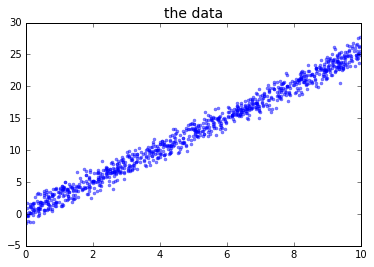

In [16]:
plt.plot(x, y, ".", alpha=0.5)
plt.title("the data", fontsize=14);

In [19]:
# let's divide the data into 10 batches
batchsize = 100
x_batches = [x[i:i+batchsize] for i in range(0, N, batchsize)]
y_batches = [y[i:i+batchsize] for i in range(0, N, batchsize)]

In [93]:
# ---- CONSTRUCTION ---- #

# first, placeholders to input data and labels to the graph
x_ph = tf.placeholder(tf.float32, shape=[batchsize,], name="x_ph")
y_ph = tf.placeholder(tf.float32, shape=[batchsize,], name="y_ph")

# now variables to hold slope and intercept
slope = tf.Variable(initial_value=0, dtype=tf.float32, name="slope")
intercept = tf.Variable(initial_value=0, dtype=tf.float32, name="intercept")
init_op = tf.variables_initializer([slope, intercept])

# build the loss function- for OLS regression, we want to minimize
# the sum of the squared difference between predictions and true
# values
predictions = slope*x_ph + intercept
squared_error = (predictions - y_ph)**2
# note that the arithmetic operations above (which are equivalent to tf.add, 
# etc) do elementwise calculations (like numpy). If we want to sum up all
# the values in a tensor, use tf.reduce_sum
RSS = tf.reduce_sum(squared_error, name="RSS")

# since we're going to use gradient descent, we need a learning rate. let's
# set a placeholder with a default (so we have the option to specify the 
# LR but we don't have to)
default_lr = tf.constant(0.00001)
learnrate = tf.placeholder_with_default(default_lr, shape=(), name="learnrate")

# pass the learning rate to an optimizer.
optimizer = tf.train.GradientDescentOptimizer(learnrate)
# the optimizer's minimize() method returns an operation we can run to
# minimize the loss function
training_op = optimizer.minimize(RSS)

If we're building a graph, we can use `get_shape()` to double-check and make sure everything looks right

In [102]:
squared_error.get_shape()

TensorShape([Dimension(100)])

In [103]:
RSS.get_shape()

TensorShape([])

In [94]:
# ---- EVALUATION ---- #
num_steps = 10  # number of training steps

# let's record the values of our parameters and the loss at every 
# step. for posterity.
rss_vals = []
slope_vals = []
intercept_vals = []

with tf.Session() as sess:
    # initialize variables
    sess.run(init_op)
    # for each training step
    for e in range(num_steps):
        print(e)
        # for each batch-
        for x_batch, y_batch in zip(x_batches, y_batches):
            fd={x_ph:x_batch, y_ph:y_batch}
            # run the optimizer, and evaluate parameters so we 
            #can record them
            _, r, s, i = sess.run([training_op, RSS, slope, intercept], feed_dict=fd)
            rss_vals.append(r)
            slope_vals.append(s)
            intercept_vals.append(i)

0
1
2
3
4
5
6
7
8
9


Let's take a look at the loss function during training:

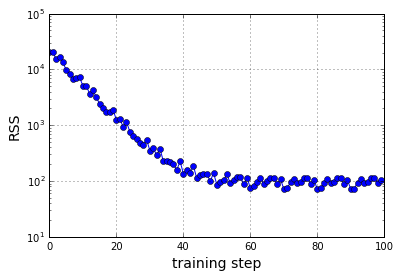

In [97]:
plt.plot(rss_vals, "o-")
plt.yscale("log")
plt.grid("on")
plt.xlabel("training step", fontsize=14)
plt.ylabel("RSS", fontsize=14);

And how the predictions update during training:

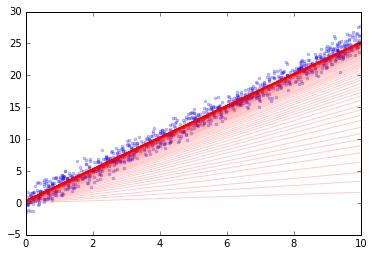

In [101]:
plt.plot(x, y, ".", alpha=0.25)
xvals = np.array([0,10])
for s, i in zip(slope_vals, intercept_vals):
    plt.plot(xvals, s*xvals+i, "r", alpha=0.2)